# TP 1: Dynamic Programming and Reinforcement Learning

by BOUJNOUNI Fatine 

## I - Dynamic Programming

In [1]:
# Imports 
import numpy as np 
import matplotlib.pyplot as plt

#### Question 1 : 

From the figure, I guess the optimal policy $\pi^*$ is ['a1', 'a1', 'a2']

#### Question 2 : 

In [12]:

class MDP():
    def __init__(self, states, actions, transitions, rewards, discount_factor):
        """
        Defines the MDP Model.
        """
        self.states = states
        self.actions = actions 
        self.transitions = transitions 
        self.rewards = rewards
        self.discount_factor = discount_factor
        
    def bellman_operator(self, V):
        """Computes the Bellmann operator for V
        It returns a vector of optimal values and it optimal policy """
        Values = V.copy()
        opti_policy = np.zeros(len(self.states))
        for s in range(len(self.states)):
            values = np.zeros(len(self.states))
            for a in range(len(self.actions)):
                values[a] = self.rewards[s,a] + self.discount_factor * np.sum(self.transitions[:,s,a] * V)
            Values[s] = np.max(values)
            opti_policy[s] = np.argmax(values)
        return Values , opti_policy
    
    def value_iteration(self, epsilon):
        """Computes the value iteration algorithm
        It returns the optimal policy and the list of value differences"""
        V = np.zeros(len(self.states))
        V_diff = 10*epsilon 
        V_diff_list =[] 
        while(V_diff > epsilon):
            newV, optimal_policy = self.bellman_operator(V)
            V_diff = np.max(np.linalg.norm(newV-V, np.inf))
            V = newV
            V_diff_list.append(V_diff)
        print("The value function of the optimal policy ",newV )

        return optimal_policy, V_diff_list
    
    def policy_evaluation(self, policy):
        Rpi = self.rewards[np.arange(len(policy)),policy]
        Tpi = self.transitions[:,np.arange(len(policy)),policy].T
        Vpi = np.linalg.solve((np.identity(Tpi.shape[0]) - self.discount_factor * Tpi), Rpi)
        return(Vpi)
    
    def policy_iteration(self, initial_policy):
        "Perform policy iteration on the graph"
        pi = initial_policy
        pi.astype(int)
        d = 1 
        while(d > 0):
            print(pi)
            V = self.policy_evaluation(pi)
            _,pprime = self.bellman_operator(V)
            d = (np.max(abs(pi-pprime)))
            pi = pprime.astype(int)
        return(pi)


In [13]:
states = np.array ([0,1,2])
actions = np.array([0,1,2])
transitions = np.zeros((3,3,3))
transitions[0] = np.array([[0.55,0.3,1],[1,0,0],[0,0,0]]) 
transitions[1] = np.array([[0.45,0.7,0],[0,0.4,1],[1,0.6,0]])
transitions[2] = np.array([[0,0,0],[0,0.6,0],[0,0.4,1]])
rewards = np.array([[0,0,5/100],[0,0,0],[0,1,9/10]])

In [14]:
transitions

array([[[0.55, 0.3 , 1.  ],
        [1.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  ]],

       [[0.45, 0.7 , 0.  ],
        [0.  , 0.4 , 1.  ],
        [1.  , 0.6 , 0.  ]],

       [[0.  , 0.  , 0.  ],
        [0.  , 0.6 , 0.  ],
        [0.  , 0.4 , 1.  ]]])

In [15]:
# MDP Model 
mdp = MDP(states, actions, transitions, rewards, 0.95)

The value function of the optimal policy  [15.3862763  16.54350617 17.99511907]
The optimal policy is : [1. 1. 2.]


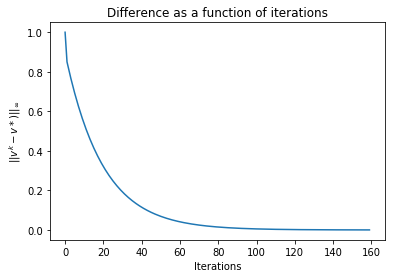

In [19]:
precision = 0.01
gamma = 0.95
epsilon = precision*(1 - gamma)/(2*gamma)
optimal_policy, value_differences = mdp.value_iteration(epsilon)
print("The optimal policy is :", optimal_policy)

plt.plot(value_differences);
plt.title("Difference as a function of iterations")
plt.xlabel("Iterations")
plt.ylabel("$||v^k - v*)||_\infty$")
plt.show()

#### Question 3 : 


In [20]:
# Question 3 :
initial_policy = np.array([0, 0, 0])
v,p,i = mdp.policy_iteration(initial_policy)

[0 0 0]
[2 0 1]
[2 1 2]
[1 1 2]


The policy iteration algorithm converges faster than the value iteration algorithm. The first one converges in 3 iterations and the second in  approximatively 160 iterations.
However, the policy iteration is more expensive because it requires a full policy evaluation in each iteration. 


## 2 - Reinforcement learning 

In [21]:
# Imports 
from gridworld import *


### Policy Evaluation 

##### Question 4 

In [22]:
Vpi = np.array([0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.67106071, -0.99447514, 0.00000000, -0.82847001, -0.87691855,
        -0.93358351, -0.99447514]).T
env = GridWorld1

In [29]:
# Tmax 
delta = 0.4
Rmax = 1
Tmax = int(round(-np.log(delta/Rmax) / (1 - env.gamma)))
Tmax

18

In [30]:
# Compute the "mu"s
def compute_MU(env, N):
    MU = np.zeros(env.n_states)
    for i in range(N):
        initial_state = env.reset()
        MU[initial_state] += 1
    MU=MU/np.sum(MU)
    return MU

def compute_R(env, initial_state, policy, Tmax):
    state = initial_state
    t = 0
    gain = 0
    t_flag = False
    coef = 1
    R = 0
    while( t < Tmax ):
        t += 1
        state, reward, t_flag = env.step(state,policy[state])
        if(t_flag):
            R += coef*reward
        else:
            coef = coef*env.gamma
            R += coef*reward
    return(R)

def compute_Vn(env, policy, N, Tmax):
    Ns = np.zeros(env.n_states)
    V  = np.zeros(env.n_states)
    Vn = np.zeros((N, env.n_states))
    for i in range(N):
        initial_state = env.reset()
        Ns[initial_state] += 1
        R = compute_R(env, initial_state, policy, Tmax)
        V[initial_state] += R
        Vn[i,:] = V/Ns
    return(Vn)
      

In [43]:
N = 10000
pol = [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3]
MU = compute_MU(env, N)
Vn = compute_Vn(env, pol, N, Tmax)
Jpi = np.dot(Vpi,MU)
Jn = np.dot(Vn,MU)

/Users/fatineboujnouni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


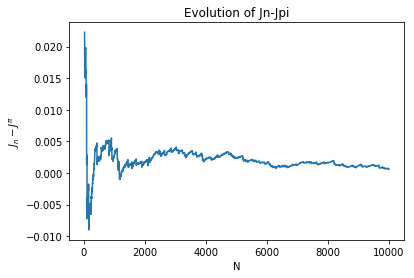

In [44]:
plt.plot((Jn-Jpi))
plt.title("Evolution of Jn-Jpi")
plt.xlabel("N")
plt.ylabel("$J_n - J^{\pi}$")
plt.show()
print()

### Policy Optimization 


#### Question 5 

In [45]:
def greedy_action(env, Q, state, epsilon):
    """ Return an action argmax(a)(Q(state, a)) with probability 1-epsilon """
    prob = np.random.random()
    current_state_actions = env.state_actions[state]

    A = current_state_actions[0]
    max_Q = Q[state,A]
    
    if prob < epsilon:
        action = np.random.choice(current_state_actions)
    else:
        #action = np.argmax(Q[state] )
        for a in current_state_actions:
            if Q[state,a] > max_Q:
                max_Q = Q[state,a]
                A = a
        action = A
    return action

def Qlearning(env, N, Tmax, epsilon, alpha):
    """ Q learning algorithm.
    It returns the optimal Q function , 
    the list of value functions at each episode
    and a list of cumulated rewards at each episode"""
    # value functions 
    values = []
    
    # Cumulated rewards
    cumulated_rewards = []
    cumulated_reward = 0
    
    # Initialization of Q
    Q = np.zeros((env.n_states, len(env.action_names)))
                
    for i in range(N):
        state = env.reset()
        t_flag = False
        for t in range(1, Tmax):
            if not t_flag:
                action = greedy_action(env, Q, state, epsilon)  
                next_state, reward, t_flag = env.step(state, action)
                Q[state][action] += alpha * (reward + env.gamma * np.max(Q[next_state]) - Q[state][action])
                state = next_state
                cumulated_reward += reward
            else:
                values.append(np.max(Q, axis=1))
                cumulated_rewards.append(cumulated_reward)
                break
    return Q, values, cumulated_rewards

In [46]:
Vprime = np.array([0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.82369294, 0.92820033, 0.00000000, 0.77818504, 0.82369294,
         0.87691855, 0.82847001]).T


In [81]:
# Test Q learning algorithm for different epsilon values
epsilons = [i*0.1 for i in range(10)]
N = 10000
alpha = 0.1

cumulated_rewards = []
value_functions = []

for e in epsilons:
    Q, V, R = Qlearning(env, N, Tmax, e, alpha)
    cumulated_rewards.append(R[-1]) # Last cumulated reward
    value_functions.append(V[-1]) # Last Value function

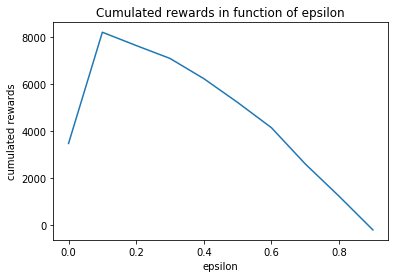

In [82]:
plt.plot(epsilons, cumulated_rewards)
plt.xlabel("epsilon")
plt.ylabel("cumulated rewards")
plt.title("Cumulated rewards in function of epsilon")
plt.show()

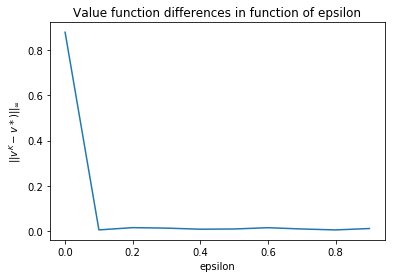

In [83]:
V_diff = [np.linalg.norm(v-Vprime, np.inf) for v in value_functions]
plt.plot(epsilons, V_diff)
plt.xlabel("epsilon")
plt.ylabel("$||v^K - v*)||_\infty$")
plt.title("Value function differences in function of epsilon")
plt.show()

According to the 2 graphs, the best epsilon to choose is 0.1 


In [90]:
N = 10000
epsilon = 0.1 
alpha = 0.1
Q, V, R = Qlearning(env, N, 90, epsilon, alpha)

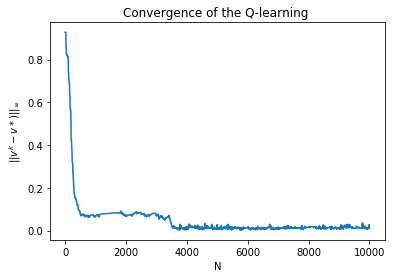

In [91]:
# Convergence of the Q-learning algorithm
V_diff = [np.linalg.norm(v-Vprime, np.inf) for v in V]
plt.plot(V_diff)
plt.ylabel("$||v^k - v*)||_\infty$")
plt.xlabel("N")
plt.title("Convergence of the Q-learning ")
plt.show()

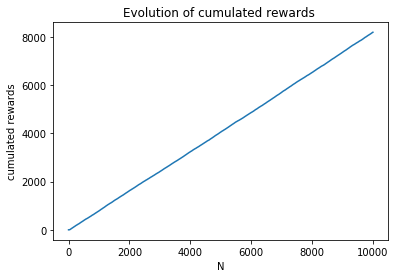

In [92]:
# Convergence of the Q-learning algorithm
plt.plot(R)
plt.ylabel("cumulated rewards")
plt.xlabel("N")
plt.title("Evolution of cumulated rewards ")
plt.show()

In [93]:
gui.render_q(env, Q)

#### Question 6:

 No, the optimal policy is not affected by $\mu_0$ , because the optimal policy works for any initial state.